# 7 classes
https://www.kaggle.com/suniliitb96/tutorial-keras-transfer-learning-with-resnet50?select=resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

In [7]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import os
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import ELU
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from keras.regularizers import l1

Using TensorFlow backend.


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import cv2
import os

In [9]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

In [11]:
# Fixed classes
NUM_CLASSES = 7
CHANNELS = 3

IMAGE_RESIZE = 48
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

In [5]:
resnet_weights_path = '/notebooks/W251_FinalProject/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [12]:
#Still not talking about our train/test data or any pre-processing.
model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = resnet_weights_path))

# 2nd layer as Dense for 7-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

ValueError: Shapes (1, 1, 256, 512) and (512, 128, 1, 1) are incompatible

In [115]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 14343     
Total params: 23,602,055
Trainable params: 14,343
Non-trainable params: 23,587,712
_________________________________________________________________


In [8]:
from tensorflow.python.keras import optimizers

sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [23]:
# ! rmdir /notebooks/data7cls_newing_randomsplit/train/.ipynb_checkpoints
# ! rmdir /notebooks/data7cls_newing_randomsplit/validation/.ipynb_checkpoints

rmdir: failed to remove '/notebooks/data7cls_newing_randomsplit/train/.ipynb_checkpoints': No such file or directory
rmdir: failed to remove '/notebooks/data7cls_newing_randomsplit/validation/.ipynb_checkpoints': No such file or directory


In [78]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
image_size = IMAGE_RESIZE

train_dir1 = "/notebooks/data7cls_newimg_randomsplit/train/"
valid_dir1 = "/notebooks/data7cls_newimg_randomsplit/validation/"

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# val_datagen = ImageDataGenerator(rescale=1./255)
# train_datagen = ImageDataGenerator(
#         rescale=1./255,
#       rotation_range=30,
#       shear_range=0.3,
#       zoom_range=0.3,
#       horizontal_flip=True,
#       fill_mode='nearest')

train_generator = data_generator.flow_from_directory(
        train_dir1,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        valid_dir1,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical') 

Found 25585 images belonging to 7 classes.
Found 6263 images belonging to 7 classes.


In [29]:
print(validation_generator.class_indices)

{'distracted': 2, 'confused': 1, 'sad': 5, 'neutral': 4, 'angry': 0, 'happy': 3, 'surprise': 6}


In [30]:
(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(validation_generator))

(100, 256, 100, 63)

In [79]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
#cb_checkpointer = ModelCheckpoint(filepath = '/notebooks/W251_FinalProject/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')
cb_checkpointer = ModelCheckpoint(filepath = '/notebooks/best1.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [80]:
# import keras
# filepath = os.path.join("/notebooks/littleVGG7cls/model_transferlearn_{epoch}.hdf5")

# checkpoint = keras.callbacks.ModelCheckpoint(filepath,
#                                              monitor='val_acc',
#                                              verbose=1,
#                                              save_best_only=True,
#                                              mode='max')
# callbacks = [checkpoint]

fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper]

)
#model.load_weights('/notebooks/W251_FinalProject/best.hdf5')



Epoch 1/10
256/256 [==============================] - 160s 625ms/step - loss: 1.7776 - acc: 0.4093 - val_loss: 1.9380 - val_acc: 0.4164
Epoch 2/10
256/256 [==============================] - 140s 546ms/step - loss: 1.6639 - acc: 0.4393 - val_loss: 1.8105 - val_acc: 0.4246
Epoch 3/10
256/256 [==============================] - 216s 845ms/step - loss: 1.6388 - acc: 0.4485 - val_loss: 1.8737 - val_acc: 0.4135
Epoch 4/10
256/256 [==============================] - 142s 554ms/step - loss: 1.6365 - acc: 0.4562 - val_loss: 1.8187 - val_acc: 0.4301
Epoch 5/10
256/256 [==============================] - 106s 413ms/step - loss: 1.6346 - acc: 0.4523 - val_loss: 1.9784 - val_acc: 0.4052


In [109]:
SAVER = "../notebooks/model_save"
model.save(os.path.join(SAVER, "model.h5"))  #saving the model on each epoc
#model.save_weights(os.path.join(SAVER, "model_weights.h5")) #saving the weights of model on each epoch

Found 6263 images belonging to 7 classes.
Confusion Matrix
[[367   3   3 151 256 118  62]
 [  3 148   4   3   3   1   0]
 [  2  20 129   3   8   0   2]
 [411   6   4 756 416 130 102]
 [283   4   0 207 544 100  78]
 [292   3   0 221 348 223  52]
 [145   2   0 100 141  38 371]]
Classification Report
              precision    recall  f1-score   support

       angry       0.24      0.38      0.30       960
    confused       0.80      0.91      0.85       162
  distracted       0.92      0.79      0.85       164
       happy       0.52      0.41      0.46      1825
     neutral       0.32      0.45      0.37      1216
         sad       0.37      0.20      0.26      1139
    surprise       0.56      0.47      0.51       797

    accuracy                           0.41      6263
   macro avg       0.53      0.52      0.51      6263
weighted avg       0.43      0.41      0.41      6263



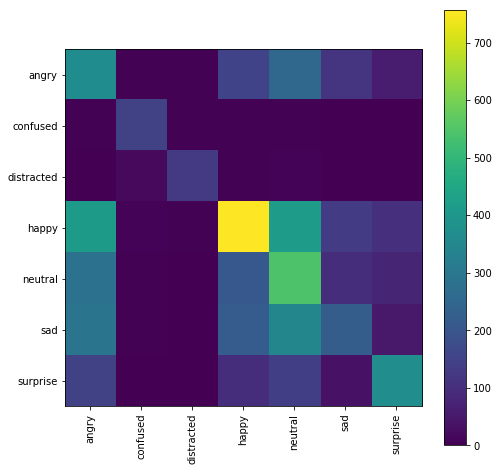

In [81]:
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
# Found 25585 images belonging to 7 classes.
# Found 6263 images belonging to 7 classes.
nb_train_samples = 25585
nb_validation_samples = 6263
batch_size=BATCH_SIZE_TESTING
# We need to recreate our validation generator with shuffle = false
validation_generator = data_generator.flow_from_directory(
        directory = '/notebooks/data7cls_newimg_randomsplit/validation',
        #color_mode = 'grayscale',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TESTING,
        class_mode='categorical',
        shuffle=False,
        seed=123)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

In [82]:
cnf_matrix

array([[367,   3,   3, 151, 256, 118,  62],
       [  3, 148,   4,   3,   3,   1,   0],
       [  2,  20, 129,   3,   8,   0,   2],
       [411,   6,   4, 756, 416, 130, 102],
       [283,   4,   0, 207, 544, 100,  78],
       [292,   3,   0, 221, 348, 223,  52],
       [145,   2,   0, 100, 141,  38, 371]])

In [83]:
cm=cnf_matrix
cm = cm.astype('float') / cm.sum(axis=1)[:,None]
cm

array([[0.38229167, 0.003125  , 0.003125  , 0.15729167, 0.26666667,
        0.12291667, 0.06458333],
       [0.01851852, 0.91358025, 0.02469136, 0.01851852, 0.01851852,
        0.00617284, 0.        ],
       [0.01219512, 0.12195122, 0.78658537, 0.01829268, 0.04878049,
        0.        , 0.01219512],
       [0.22520548, 0.00328767, 0.00219178, 0.41424658, 0.22794521,
        0.07123288, 0.05589041],
       [0.23273026, 0.00328947, 0.        , 0.17023026, 0.44736842,
        0.08223684, 0.06414474],
       [0.25636523, 0.00263389, 0.        , 0.19402985, 0.30553117,
        0.19578578, 0.04565408],
       [0.18193225, 0.00250941, 0.        , 0.12547051, 0.17691343,
        0.0476788 , 0.46549561]])

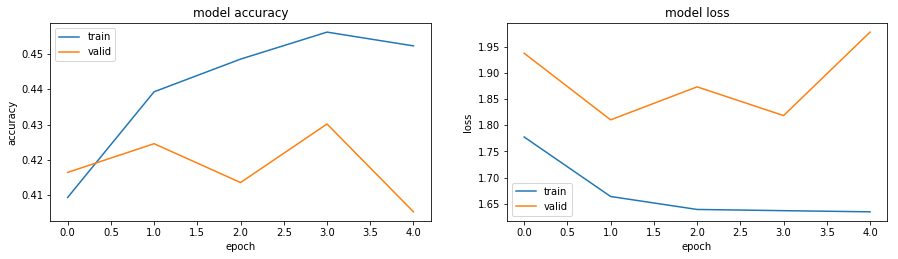

In [84]:
 plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['acc'])  
plt.plot(fit_history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

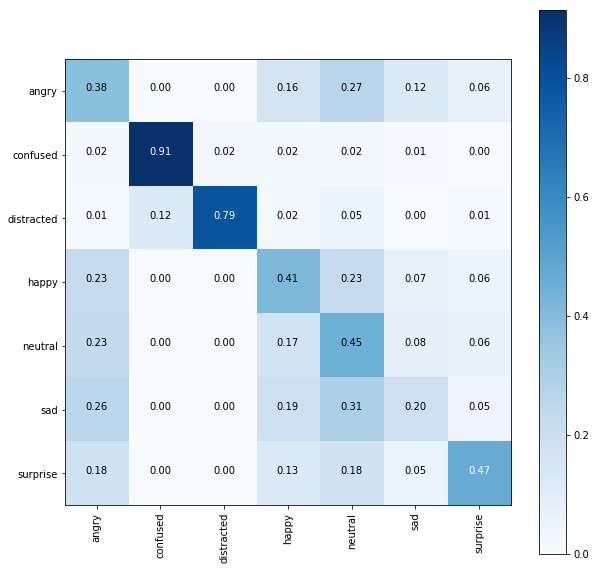

In [85]:
import itertools
cm=cnf_matrix
cm = cm.astype('float') / cm.sum(axis=1)[:,None]
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

fmt = '.2f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")